# Lab 3 — recommender systems

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.style.use("ggplot")

What does the data look like?

In [2]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


In [3]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

### Ex 3.4 Basic statistics
#### First, we will look at basic statistics on this dataset.\n",
- Plot the number of ratings for each user
- Plot the number of ratings for each item
#### Is the number of ratings balanced uniformly across users and movies?

In [4]:
# Take the first 5 sets of the data
print(data.take(5))

[{'movieId': 2, 'userId': 1, 'timestamp': 1112486027, 'rating': 3.5}, {'movieId': 29, 'userId': 1, 'timestamp': 1112484676, 'rating': 3.5}, {'movieId': 32, 'userId': 1, 'timestamp': 1112484819, 'rating': 3.5}, {'movieId': 47, 'userId': 1, 'timestamp': 1112484727, 'rating': 3.5}, {'movieId': 50, 'userId': 1, 'timestamp': 1112484580, 'rating': 3.5}]


In [5]:
userId_rating = data.map(lambda r: (r['userId'], r['rating']))
movieId_rating = data.map(lambda r: (r['movieId'], r['rating']))

In [6]:
# Count by userId and movieId
dict_userId_rating = userId_rating.countByKey().items()
dict_movieId_rating = movieId_rating.countByKey().items()

lst_userId_rating = list(dict_userId_rating)
lst_movieId_rating = list(dict_movieId_rating)

In [7]:
lst_u_rating = []
lst_m_rating = []

for i in lst_userId_rating:
    lst_u_rating.append(i[1])
    
for i in lst_movieId_rating:
    lst_m_rating.append(i[1])

Text(0,0.5,'rating')

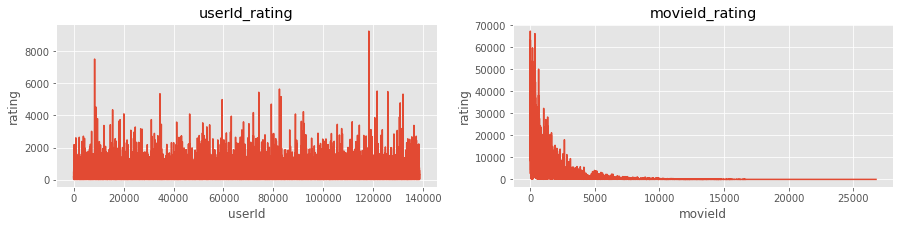

In [10]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))
    
ax1.plot(lst_u_rating)
ax1.set_title("userId_rating")
ax1.set_xlabel("userId")
ax1.set_ylabel("rating")
    
ax2.plot(lst_m_rating)
ax2.set_title("movieId_rating")
ax2.set_xlabel("movieId")
ax2.set_ylabel("rating")

### Is the number of ratings balanced uniformly across users and movies?
- No. Number of ratings differs much among users and movies.
#### MovieId_rating looks like an exponential, so try to make log graphs"

In [11]:
# Make log plot graphs
lst_u_rating_sorted = lst_u_rating.sort()
lst_m_rating_sorted = lst_m_rating.sort()

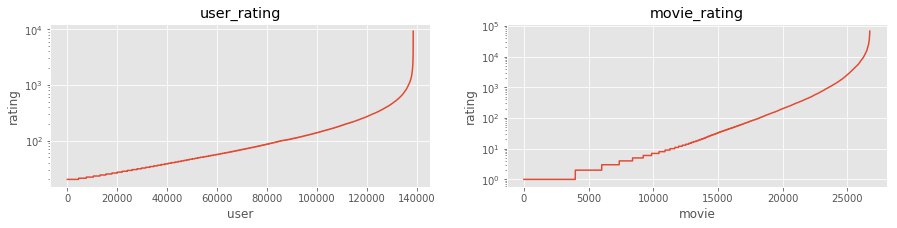

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))
    
ax1.plot(lst_u_rating)
ax1.set_title("user_rating")
ax1.set_xlabel("user")
ax1.set_ylabel("rating")
    
ax2.plot(lst_m_rating)
ax2.set_title("movie_rating")
ax2.set_xlabel("movie")
ax2.set_ylabel("rating")
    
ax1.set_yscale('log')
ax2.set_yscale('log')

### Ex 3.5 Partitioning the dataset

#### In order to tune hyperparameters and evaluate the recommender system’s performance, we will split the data into a training and a validation set
- Append your personal ratings to the MovieLens dataset RDD.
- Partition the data into two sets: ≈ 80% for training, and ≈ 20% for validation.

In [14]:
f = open('my-ratings.txt')
data1 = f.read().splitlines()
f.close()

personal_data = sc.parallelize(data1).map(json.loads)

# Union the original data and the personal data
unioned_data = data.union(personal_data)

### Partition the data by the last digit of the rating’s timestamp.
- 0 or 1 -> training
- 2 to 9 -> validation

In [15]:
# Partition the data into two sets\n",
training_row = unioned_data.filter(lambda r: (r['timestamp'] % 10) >= 2)
validation_row = unioned_data.filter(lambda r: (r['timestamp'] % 10) <= 1)

# Map the row data with ['userId'], ['movieId'], ['rating']
training = training_row.map(lambda r: (r['userId'],r['movieId'], r['rating']))
validation = validation_row.map(lambda r: (r['userId'],r['movieId'], r['rating']))

In [18]:
# Count the size of each data
# Preparetion for calculating the proportion
data_size = data.count()
training_size = training.count()
validation_size = validation.count()

In [19]:
print("Training ratio is {:.4f}".format(training_size/data_size))
print("Validation ratio is {:.4f}".format(validation_size/data_size))

Training ratio is 0.8000
Validation ratio is 0.2000


### Ex 3.6 Baseline model

#### You will first implement a recommender system based on model (3.1).
- Compute the global mean µ, the user biases {αu} and the item biases {βm} using asequence of RDD transformations on the training set.
- How many parameters does this model have?
- Predict the rating of every user / movie pair in the validation set.
#### Note: some users / movies do not have any ratings. Use sensible default values for αu and βm.

### Global mean

In [21]:
# Take the first 5 sets of the data
training.take(5)

[(1, 2, 3.5), (1, 29, 3.5), (1, 32, 3.5), (1, 47, 3.5), (1, 151, 4.0)]

In [22]:
def µ_calculation(rdd):
    # Extract the rating values
    rdd_rating = rdd.map(lambda x: x[2])
    # Mean all of the rating values
    return rdd_rating.mean()

In [27]:
µ = µ_calculation(training)
print(µ)

3.525507523913309


###  The user biases {αu} and the item biases {βm}

In [28]:
def cumulate_by_key(rdd):
    return rdd.reduceByKey(lambda x, y: x + y).sortByKey()

In [29]:
def count_by_key_rdd(rdd):
    dict_rdd_count = rdd.countByKey().items()
    return sc.parallelize(dict_rdd_count)

In [31]:
def change_list_dict(lst):
    dic = {}
    for i in lst:
        dic[i[0]] = i[1]
    return dic

In [32]:
def key_bias(rdd):
    # Cumulate the rating values for each key
    cum_rdd = cumulate_by_key(rdd)

    # Count the number of ratings for each key
    count_rdd = count_by_key_rdd(rdd)

    # Join the two sets by their keys
    joined_rdd = cum_rdd.leftOuterJoin(count_rdd).sortByKey()
    
    # Calculate the user bias for each user
    lst_key_bias = joined_rdd.map(lambda a: (a[0], a[1][0] / a[1][1])).collect()
 
    # Finally, change the list to a dictionary
    dict_key_bias = change_list_dict(lst_key_bias)

    return dict_key_bias

In [33]:
# Minus µ from all of the rating values
user_rating_µ = training.map(lambda r: (r[0], r[2] - µ))

# Minus µ and user bias from all of the rating values
movie_rating_µ = training.map(lambda r: (r[1], r[2] - user_bias[r[0]] - µ))

In [34]:
user_bias = key_bias(user_rating_µ)
movie_bias = key_bias(movie_rating_µ)

In [35]:
# Take a look at the user_bias of  user 1 - 10
list(user_bias.items())[0:10]

[(1, 0.23335772431364177),
 (2, 0.436030937625153),
 (3, 0.5565820283254965),
 (4, 0.14115914275335775),
 (5, 0.8707188911810303),
 (6, 0.22449247608669146),
 (7, -0.24178659368075192),
 (8, 0.22920945721876665),
 (9, -0.5731265715323564),
 (10, 0.37104420022462237)]

In [36]:
# Take a look at the movie_bias of  movie 1 - 10
list(movie_bias.items())[0:10]

[(1, 0.31480820932448517),
 (2, -0.30951623486223406),
 (3, -0.35562033927475983),
 (4, -0.6073047711237973),
 (5, -0.44419014219463354),
 (6, 0.28629055142985504),
 (7, -0.1534754035829518),
 (8, -0.3263704522148527),
 (9, -0.448326065115885),
 (10, -0.11424654611260533)]

### Predicting the rating

In [37]:
def mean_value(dic):
    lst_values = dic.values()
    return sum(lst_values)/len(lst_values)

In [38]:
mean_user_bias = mean_value(user_bias)
mean_movie_bias = mean_value(movie_bias)

In [39]:
mean_user_bias

0.10161003152750508

In [40]:
mean_movie_bias

-0.20496287447613265

In [41]:
userId_movieId = validation.map(lambda x: (x[0], x[1]))

In [42]:
# Use mean value for users and movies who don't have any ratings.\n",
def user_bias_modify(userId):
    if userId in user_bias.keys():
        return user_bias[userId]
    return mean_user_bias
    
def movie_bias_modify(movieId):
    if movieId in movie_bias.keys():
        return movie_bias[movieId]
    return mean_movie_bias

In [43]:
predictions = userId_movieId.map(lambda x:
                                 (x[0], x[1], µ + user_bias_modify(x[0]) + movie_bias_modify(x[1])))

In [44]:
predictions.take(10)

[(1, 50, 4.467954194198162),
 (1, 112, 3.68850604263758),
 (1, 253, 3.7216453682283666),
 (1, 367, 3.3938553801249585),
 (1, 593, 4.302769002501195),
 (1, 653, 3.467272136627635),
 (1, 919, 4.125647231988072),
 (1, 1036, 4.100066677848261),
 (1, 1097, 3.920970086894223),
 (1, 1193, 4.352077055355453)]

###  Ex 3.7 Evaluation

Implement a function error() that takes an RDD containing (userId, movieId, rating) triplets and computes the error (3.2) with respect to the validation set.
- Use this function to evaluate the baseline predictions that you computed previously.
- You should obtain an error of approximately 0.867.

In [45]:
# Calculates an error
# used for evaluation of the recommender systems
def error(predictions, validation):
   # Attach keys to values in the prediction and validation sets
    predictions_by_user_product = predictions.map(lambda r: ((r[0], r[1]), r[2]))
    validations_by_user_product = validation.map(lambda r: ((r[0], r[1]), r[2]))

    # Join the two sets by their keys (user, product)
    joined_by_user_product = predictions_by_user_product.join(validations_by_user_product)

    # Calculate the square of the differences for each pair of validation and prediction
    # and re-key by user
    sq_differences_by_user = (joined_by_user_product
        .map(lambda x: (x[0][0], (x[1][0] - x[1][1])**2)))

    # Take the squareroot of the mean of the square differences from above
    # on a user-by-user basis to get each user's error
    user_errors = (sq_differences_by_user
        .map(lambda x: (x[0], (x[1], 1)))
        .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
        .map(lambda x: np.sqrt(x[1][0] / x[1][1])))

    # Finally, take the mean of the each user's error
    mean_error = user_errors.mean()

    return mean_error

In [46]:
error(predictions, validation)

0.86837074922015067